# Semantic Segmentaion Mask 모델을 사용하여 인물 사진을 수정해보자

__< 오늘의 목표 >__
1. 미리 학습된 모델의 가중치를 불러온다
2. 모델에 원하는 이미지를 입력하여 객체를 구분하는 마스크를 제작한다
3. 마스크와 원본 사진을 활용하여 원하는 기능을 구현한다

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path = os.getenv("HOME")+'/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(2320, 3088, 3)


## 이미 학습된 모델을 불러오자
1. ```def __init__(self)``` :
    - url 을 통해 다운로드 받은 모델 가중치 및 구조 정보
    - ```tf.compat.v1.Session(graph=self.graph``` 에 필요한 구조 정보를 로드

2. ```def run(self)``` 부분에서 실제 입력과 학습을 진행

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(2320, 3088, 3) (385, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 미리 학습된 모델을 사용하여 Segmentation mask 생성
__1) 내 사진을 이용하여 배경 블러 기능을 구현__

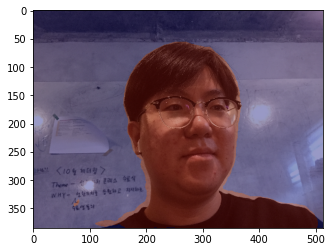

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15,15,0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* 모델을 통해 출력된 마스크를 실제 이미지에 매칭할 수 있도록 업사이즈

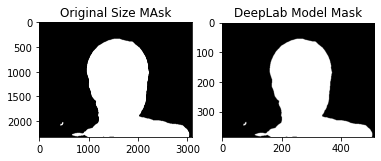

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128,255,cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size MAsk')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title("DeepLab Model Mask")

plt.show()

* 배경을 포함한 전체 이미지에 블러 효과를 적용
* 마스크와 배경을 concat 수행하기 위해, 배경에서 마스크가 차지하는 영역을 제거함
* 마스크와 배경의 경계에서 객체가 실제 차지하는 영역보다 배경쪽으로 더 넓게 마스킹 된것을 확인할 수 있다

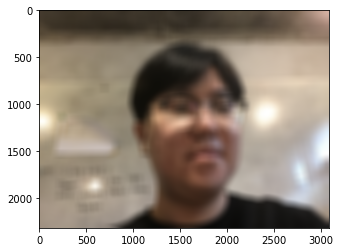

In [9]:
img_orig_blur = cv2.blur(img_orig, (100,100))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

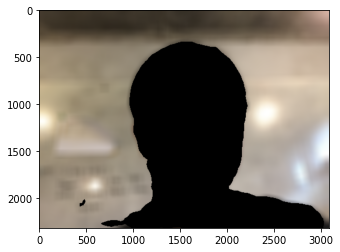

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

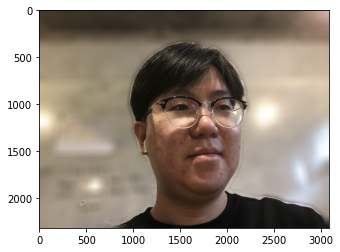

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

__2) 고양이 사진__

고양이 이미지 로드 \
모델 사용을 위한 인스턴스 생성

In [25]:
img_cat_path = os.getenv("HOME")+'/aiffel/human_segmentation/images/cat.png'
img_cat_orig = cv2.imread(img_cat_path)
print(img_cat_orig.shape)
CAT_1 = DeepLabModel(download_path)
print('model loaded successfully!')

(2577, 3707, 3)
model loaded successfully!


In [34]:
img_resized, seg_map = CAT_1.run(img_cat_orig)
print(img_cat_orig.shape, img_resized.shape, seg_map.max())

(2577, 3707, 3) (356, 513, 3) 8


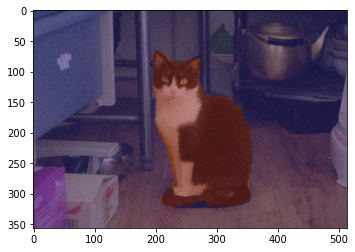

In [35]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8,8,0)  # 예측 중 고양이(label=8)만 추출
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

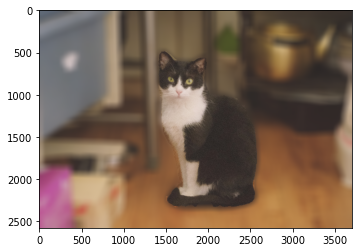

고양이가 세상을 구하는 그날까지!!


In [41]:
img_mask_up = cv2.resize(img_mask, img_cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128,255,cv2.THRESH_BINARY)

img_cat_orig_blur = cv2.blur(img_cat_orig, (100,100))

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_cat_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_cat_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
print('고양이가 세상을 구하는 그날까지!!')

__3) 크로마키 배경전환__
1. 배경 이미지를 고양이 사진에 맞춰 리사이즈
2. 마스크 영역 제거 후 합성

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

In [42]:
img_back_path = os.getenv("HOME")+'/aiffel/human_segmentation/images/background.png'
img_back = cv2.imread(img_back_path)
print(img_back.shape)

(250, 250, 3)


In [47]:
# def preprocess(self, img_orig):
#     height, width = img_orig.shape[:2]
#     resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
#     target_size = (int(resize_ratio * width), int(resize_ratio * height))
#     resized_image = cv2.resize(img_orig, target_size)
#     resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
#     img_input = resized_rgb
#     return img_input
print(img_cat_orig.shape, img_resized.shape)

img_back_resized = CAT_1.preprocess(img_back)
print(img_back_resized.shape)

(356, 513, 3)
(513, 513, 3)


In [ ]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()